In [1]:
import pandas as pd

nifty100_df = pd.read_csv('nifty100.csv')
tickers = [ f'NSE:{n}-EQ' for n in nifty100_df.Symbol.tolist()]

In [2]:
from fyers_helper import prepare_data, load_stock_data
import datetime as dt

data_path = "../data"

end_date = dt.datetime.now()
start_date = dt.datetime(2015, 1, 1)

file_paths = prepare_data(tickers, "1D", start_date=start_date, end_date=end_date, path=data_path, overwrite=False)
loaded_data = load_stock_data(file_paths, data_path, "1D")

Loading 1Dmin data: 100%|██████████| 100/100 [00:00<00:00, 488.34it/s]


In [3]:
ohlc_dict = {
    'Open': 'first',
    'Close': 'last',
    'exit_time': 'last'
}

df = pd.concat(loaded_data, names=["Stock", "Date"]).reset_index()
# df = df[df.Date > '2023-01-01'].reset_index(drop=True)
df['exit_time'] = df.Date
# df = df.set_index(['Stock', 'Date']).sort_index()
df = df.groupby('Stock').resample('MS', on='Date').agg(ohlc_dict)

In [4]:
df['entry_price'] = df.groupby('Stock')['Open'].shift(-1)
df['exit_price'] = df.groupby('Stock')['Close'].shift(-6)
df['exit_time'] = df.groupby('Stock')['exit_time'].shift(-6)
df['returns'] = df.groupby('Stock')['Close'].diff()
df['returns_perc'] = df.groupby('Stock')['Close'].pct_change()
df['next_month_returns'] = df.groupby('Stock')['returns'].shift(-1)
df['next_month_returns_perc'] = df.groupby('Stock')['returns_perc'].shift(-1)

In [5]:
df = df.dropna()

In [6]:
from sklearn.linear_model import LinearRegression

def rolling_monthly_slope_fitness(df, window=12):
    df = df.sort_values(['Stock', 'Date'])
    results = []
    for stock, group in df.groupby('Stock'):
        group = group.reset_index(drop=True)
        group['Date_ordinal'] = group['Date'].map(lambda x: x.toordinal())
        for i in range(len(group) - window + 1):
            window_df = group.iloc[i:i+window]
            X = window_df['Date_ordinal'].values.reshape(-1, 1)
            y = window_df['Close'].values
            model = LinearRegression().fit(X, y)
            slope = model.coef_[0]
            fitness = model.score(X, y)  # R² score
            results.append({
                'Stock': stock,
                'Start_Date': window_df['Date'].iloc[0],
                'End_Date': window_df['Date'].iloc[-1],
                f'Slope_{window}m': slope,
                f'Fitness_{window}m': fitness
            })
    return pd.DataFrame(results).set_index(['Stock', 'End_Date'])

# Usage:
slope_12m = rolling_monthly_slope_fitness(df.reset_index(), window=12)
slope_12m['score'] = slope_12m['Slope_12m'] * slope_12m['Fitness_12m']

In [7]:
def top_n(_df, n, mask=None):
    dfs = []
    for idx, row in _df.groupby('End_Date'):
        date_mask = []
        if mask is not None:
            date_mask = mask.loc[idx].index.tolist()
            dfs.append(row.loc[date_mask].score.nlargest(n))
        else:
            dfs.append(row.score.nlargest(n))
    return pd.concat(dfs)

top_n = top_n(slope_12m, 50)
top_n = top_n.swaplevel('Stock', 'End_Date').sort_index()

                      Metrics                    Values
0                      Period  2016-01-01 to 2025-08-29
1            Starting capital                    600000
2               Final capital                5179246.11
3                Total Trades                      5385
4                     Winners                      3599
5                      Losers                      1786
6               Profit factor                  3.549026
7       Active Position Count                         0
8   Max holding period (days)                       214
9   Avg holding period (days)                       211
10               Win Rate (%)                 66.833798
11               Total Profit                4579246.11
12            Total Brokerage                       0.0
13                  Total Tax                  16215.08
14                  Total MTF                       N/A
15                   CAGR (%)                 25.001435
16          Max Drawdown (%):                  9

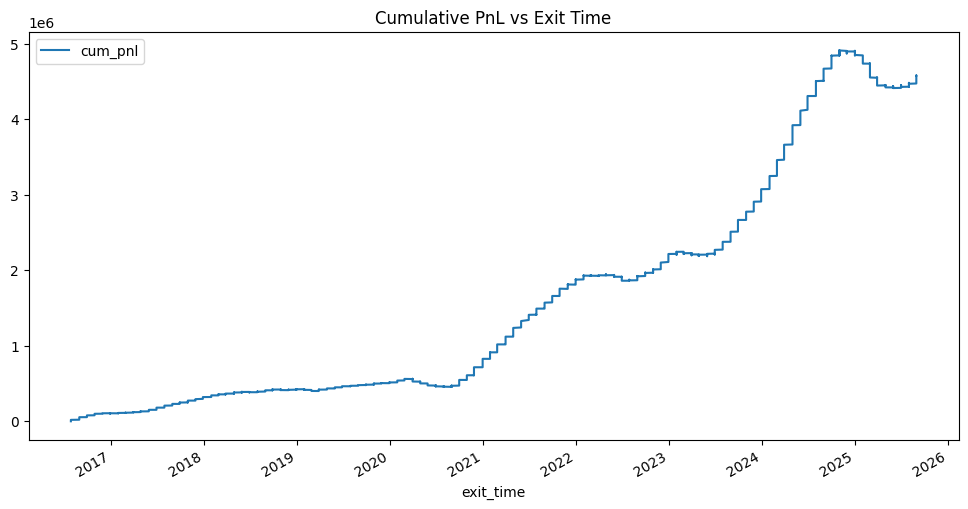

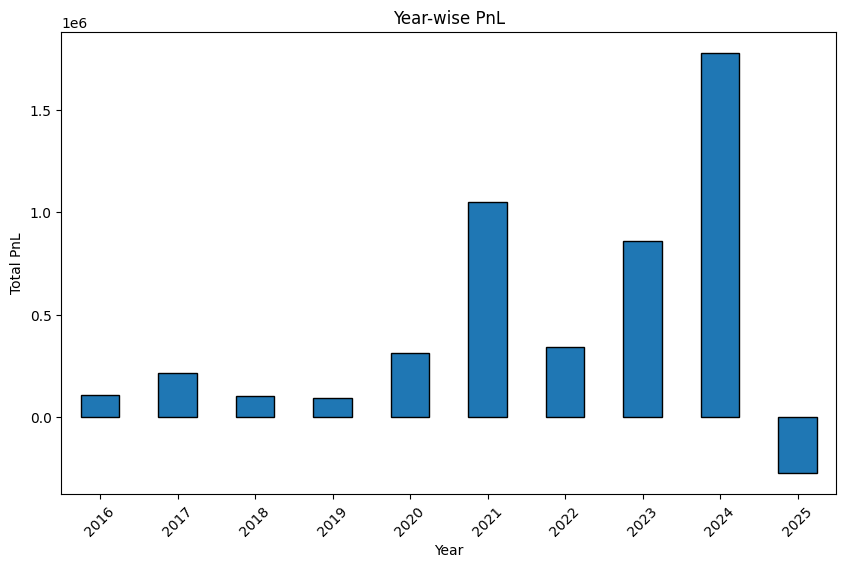

In [8]:
from lib import Bank, PositionManager, generate_tearsheet, show_equity_curve

initial_capital = 600000
leverage = 1
buckets = 6


def backtest(pm: PositionManager):
    data = df[df.index.get_level_values(1) >= start_date].dropna(subset=['entry_price', 'exit_price'])
    for idx, group in data.groupby('Date'):
        date = idx
        try:
            selected_stocks = top_n.loc[date].index.tolist()
        except Exception as e:
            continue
        capital_split = round(pm.bank.total_capital() / buckets / len(selected_stocks), 2)
        for s in selected_stocks:
            d = group.loc[(s, date)]
            capital = d['entry_price'] * round(capital_split/d['entry_price'])
            pm.new_position(s, date, d['entry_price'], capital)
        
        for s in selected_stocks:
            if pm.get_position(s) is not None:
                d = group.loc[(s, date)]
                pm.close_position(s, d['exit_time'], d['exit_price'])

    return generate_tearsheet(initial_capital, pm)

if __name__ == "__main__":
    bank = Bank(initial_capital)
    pm = PositionManager(bank, leverage=leverage)
    tearsheet, trades = backtest(pm)
    print(pd.DataFrame({
        "Metrics": tearsheet.keys(),
        "Values": tearsheet.values(),
    }))
    show_equity_curve(trades)

In [9]:
from lib import generate_tearsheet

ts, _ = generate_tearsheet(initial_capital, pm, trades[trades.exit_time.dt.date < dt.date(2020,1,1)])
print(pd.DataFrame({
    "Metrics": ts.keys(),
    "Values": ts.values(),
}))

                      Metrics                    Values
0                      Period  2016-01-01 to 2019-12-31
1            Starting capital                    600000
2               Final capital                1114245.46
3                Total Trades                      2030
4                     Winners                      1341
5                      Losers                       689
6               Profit factor                  3.106683
7       Active Position Count                         0
8   Max holding period (days)                       214
9   Avg holding period (days)                       211
10               Win Rate (%)                 66.059113
11               Total Profit                 514245.46
12            Total Brokerage                       0.0
13                  Total Tax                    2489.4
14                  Total MTF                       N/A
15                   CAGR (%)                 16.749072
16          Max Drawdown (%):                  2

/Users/abhilashnanda/code/strategy-notebooks/notebooks/lib.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trades['entry_time'] = pd.to_datetime(trades['entry_time'])
/Users/abhilashnanda/code/strategy-notebooks/notebooks/lib.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trades['exit_time'] = pd.to_datetime(trades['exit_time'])
/Users/abhilashnanda/code/strategy-notebooks/notebooks/lib.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using